In [1]:
import pandas as pd
import numpy as np
import oracledb
from sqlalchemy import create_engine
import os
import glob
pd.set_option('display.max_columns',100)
import time
import seaborn as sns
import matplotlib.pyplot as plt

- Bad debt: Accounts with >=30 days DPD

# A. Query Data

In [2]:
# credentials
username = os.environ['DBA_USR']
password = os.environ['DBA_PW']
host = '10.220.50.121'
port = '1661'
service_name = 'ANALYTIC'

In [3]:
connection_string = f'oracle+oracledb://{username}:{password}@{host}:{port}/?service_name={service_name}'

In [4]:
# create engine
engine = create_engine(connection_string)

In [5]:
# create list of all dates
allDates = ['20241031','20240930','20240829','20240731','20240628','20240531',
            '20240430','20240328','20240229','20240131','20231229','20231130']
# no dpd for <202404

In [6]:
# open sql file 360
with open("CCPull_CUST360.sql", 'r') as file:
    query_360 = file.read()

# open sql PORTFOLIO
with open("CCPull_CUSTPORT.sql", 'r') as file:
    query_PORTFOLIO = file.read()

In [7]:
# print(query_template.format(dt='20241031'))

In [8]:
allMLs = []
for date in allDates:
    yearmonth = date[2:6]
    if int(date) > 20240329:
        try:
            # print in case of errors
            print(f'Running {date}')

            # open and read the file as a single buffer
            sqlQuery = query_360.format(dt=date)

            # run query and store data in df
            print('SQL run')
            with engine.connect() as connection:
                ML = pd.read_sql(sqlQuery, connection) 
            print(f'{date} queried successfully')

            # change column names into UPPER CASE
            ML.columns = [x.upper() for x in ML.columns]
        except Exception as e:
            print(e)
            ML = pd.DataFrame()
        finally:
            allMLs.append(ML)

            time.sleep(5)
    else:
        try:
            # print in case of errors
            print(f'Running {date}')

            # open and read the file as a single buffer
            sqlQuery = query_PORTFOLIO.format(dt=date, ym=yearmonth)

            # run query and store data in df
            print('SQL run')
            with engine.connect() as connection:
                ML = pd.read_sql(sqlQuery, connection) 
            print(f'{date} queried successfully')

            # change column names into UPPER CASE
            ML.columns = [x.upper() for x in ML.columns]
        except Exception as e:
            print(e)
            ML = pd.DataFrame()
        finally:
            allMLs.append(ML)

            time.sleep(5)

Running 20241031
SQL run
20241031 queried successfully
Running 20240930
SQL run
20240930 queried successfully
Running 20240829
SQL run
20240829 queried successfully
Running 20240731
SQL run
20240731 queried successfully
Running 20240628
SQL run
20240628 queried successfully
Running 20240531
SQL run
20240531 queried successfully
Running 20240430
SQL run
20240430 queried successfully
Running 20240328
SQL run
20240328 queried successfully
Running 20240229
SQL run
20240229 queried successfully
Running 20240131
SQL run
20240131 queried successfully
Running 20231229
SQL run
20231229 queried successfully
Running 20231130
SQL run
20231130 queried successfully


In [25]:
allMLs[7].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182350 entries, 0 to 182349
Data columns (total 79 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   BASE_DT           182350 non-null  object        
 1   AGREE_ID          182350 non-null  object        
 2   GCIF_NO           182350 non-null  object        
 3   CIF_NO            182350 non-null  object        
 4   NOTE_NO           182350 non-null  object        
 5   PRD_TP            182350 non-null  object        
 6   PRD_NM            182350 non-null  object        
 7   PRD_SEGMENT       182350 non-null  object        
 8   ORG_LMT_AMT       182350 non-null  float64       
 9   CURR_LMT_AMT      182350 non-null  float64       
 10  BAL               182350 non-null  float64       
 11  ORIG_INT_RT       182350 non-null  float64       
 12  CURR_INT_RT       182350 non-null  float64       
 13  OTH_CURR_INT_RT   182350 non-null  float64       
 14  CLCT

# B. EDA

## 1. By Account

In [26]:
# concat all MLs into one
MLs = pd.concat(allMLs, ignore_index=True)

In [ ]:
# show all df cols
MLs.columns

Index(['BASE_DT', 'AGREE_ID', 'GCIF_NO', 'CIF_NO', 'NOTE_NO', 'PRD_TP',
       'PRD_NM', 'PRD_SEGMENT', 'ORG_LMT_AMT', 'CURR_LMT_AMT', 'BAL',
       'ORIG_INT_RT', 'CURR_INT_RT', 'OTH_CURR_INT_RT', 'CLCT_RTNG_FCL',
       'ALLOW_PCT', 'ALLOW_PCT_ADD', 'RESTRUCT_CD', 'PASTDUE_SINCE_DT',
       'PASTDUE_DAYS', 'WRITE_OFF_AMT', 'WRITE_OFF_DT', 'WRITE_OFF_YN',
       'CC_STATUS', 'GCIF_NO', 'SEGMENT', 'CUST_NM', 'OPEN_DATE',
       'LAST_ACTIVE_DATE', 'CUST_TP', 'GENDER_CD', 'AGE', 'SAGA_FLAG',
       'EMPLOYMENT_TYPE', 'CA_BAL', 'CA_AVG', 'SA_BAL', 'SA_AVG', 'TD_NOA',
       'TD_BAL', 'TD_AVG', 'SY_FUNDING_BAL', 'SY_FUNDING_AVG', 'FUNDING_NOA',
       'FUNDING_BAL', 'FUNDING_AVG', 'NOA_DORMANT', 'CC_PLAFOND', 'CC_BAL',
       'PL_PLAFOND', 'PLOAN_BAL', 'TR_PLAFOND', 'TR_BAL', 'PB_PLAFOND',
       'PB_BAL', 'PRK_PLAFOND', 'PRK_BAL', 'PPB_PLAFOND', 'PPB_BAL',
       'BG_PLAFOND', 'BG_BAL', 'LC_PLAFOND', 'LC_BAL', 'SY_LOAN_PLAFOND',
       'SY_LOAN_BAL', 'KPR_PLAFOND', 'KPR_BAL', 'KPM_PLAFON

In [ ]:
# drop in case of duplicated colname
MLs = MLs.loc[:, ~MLs.columns.duplicated()].copy()

In [ ]:
# check saga value count
MLs['SAGA_FLAG'].value_counts()

SAGA_FLAG
NON-SAGA    1209373
SAGA         941609
Name: count, dtype: int64

### a. SAGA vs ALL Bad Debt

In [135]:
# SAGA delinquency aggregate
SAGADeliCount = MLs[(MLs['CC_STATUS']=='DELINQUENT') & (MLs['SAGA_FLAG']=='SAGA')][[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
SAGADeliCount['MICRO_SEGMENT'] = 'SAGA'
SAGADeliCount['CATEGORY'] = 'DELINQUENT'

In [197]:
# Total delinquency aggregate
TotalDeliCount = MLs[(MLs['CC_STATUS']=='DELINQUENT')][[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
TotalDeliCount['MICRO_SEGMENT'] = 'ALL'
TotalDeliCount['CATEGORY'] = 'DELINQUENT'

In [117]:
# concat deli count
AllDeliCount = pd.concat([SAGADeliCount, TotalDeliCount], ignore_index=True)

# format data
AllDeliCount['BASE_DT'] = AllDeliCount['BASE_DT'].str[2:6]

<Axes: title={'center': 'DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

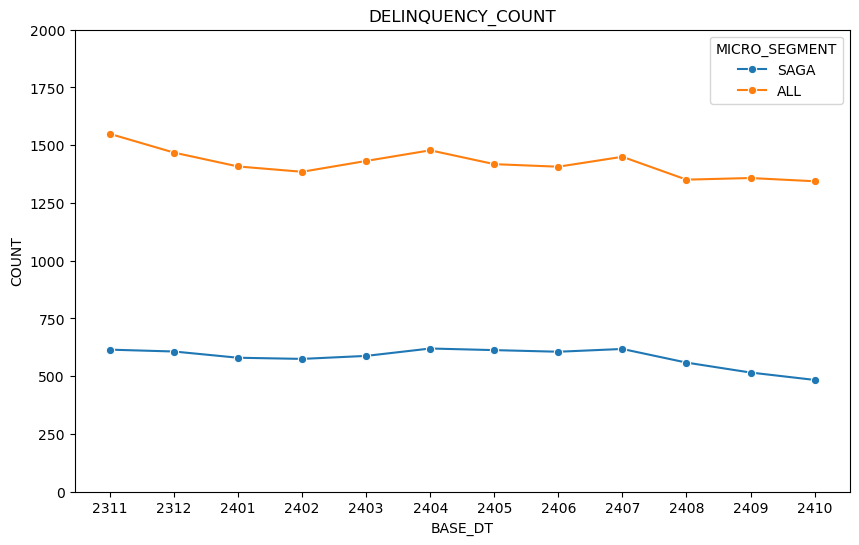

In [128]:
# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
plt.ylim((0,2000))
sns.lineplot(data=AllDeliCount, x="BASE_DT", y='ACCT_COUNT', hue='MICRO_SEGMENT', marker="o")

<Axes: title={'center': 'DELINQUENT_OS'}, xlabel='BASE_DT', ylabel='AMOUNT'>

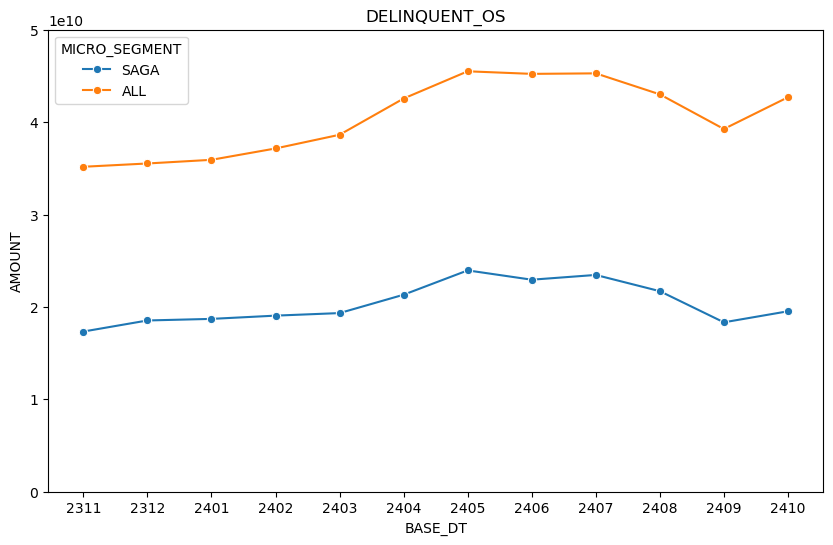

In [130]:
# Plot delinquent OS per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENT_OS")
plt.xlabel("BASE_DT")
plt.ylabel("AMOUNT")
plt.ylim((0,50000000000))
sns.lineplot(data=AllDeliCount, x="BASE_DT", y='OS', hue='MICRO_SEGMENT', marker="o")

### b. SAGA Total vs Bad

In [201]:
# Total delinquency aggregate
SAGACount = MLs[(MLs['SAGA_FLAG']=='SAGA')][[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
SAGACount['MICRO_SEGMENT'] = 'SAGA'
SAGACount['CATEGORY'] = 'ALL'

In [202]:
# concat the data
AllSAGACount = pd.concat([SAGADeliCount, SAGACount], ignore_index=True)

# format base_dt
AllSAGACount['BASE_DT'] = AllSAGACount['BASE_DT'].str[2:6]

In [203]:
AllSAGACount

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,2311,615,1.733557e+10,SAGA,DELINQUENT
1,2312,607,1.853377e+10,SAGA,DELINQUENT
2,2401,580,1.870545e+10,SAGA,DELINQUENT
3,2402,575,1.905721e+10,SAGA,DELINQUENT
4,2403,588,1.933312e+10,SAGA,DELINQUENT
5,2404,620,2.132075e+10,SAGA,DELINQUENT
6,2405,613,2.395302e+10,SAGA,DELINQUENT
7,2406,606,2.294629e+10,SAGA,DELINQUENT
8,2407,618,2.346099e+10,SAGA,DELINQUENT
9,2408,559,2.170487e+10,SAGA,DELINQUENT


<Axes: title={'center': 'SAGA_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

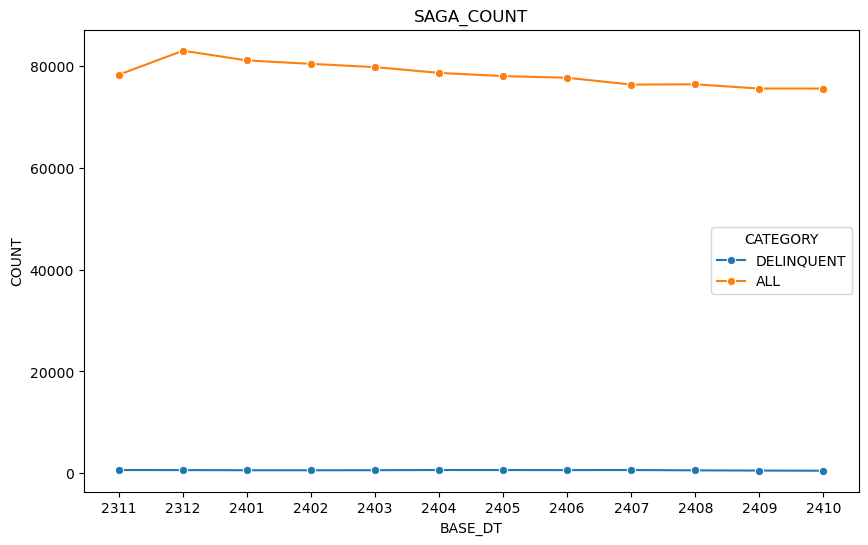

In [204]:
# Plot SAGA count per month
plt.figure(figsize=(10,6))
plt.title("SAGA_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllSAGACount, x="BASE_DT", y='ACCT_COUNT', hue='CATEGORY', marker="o")

<Axes: title={'center': 'SAGA_OS'}, xlabel='BASE_DT', ylabel='COUNT'>

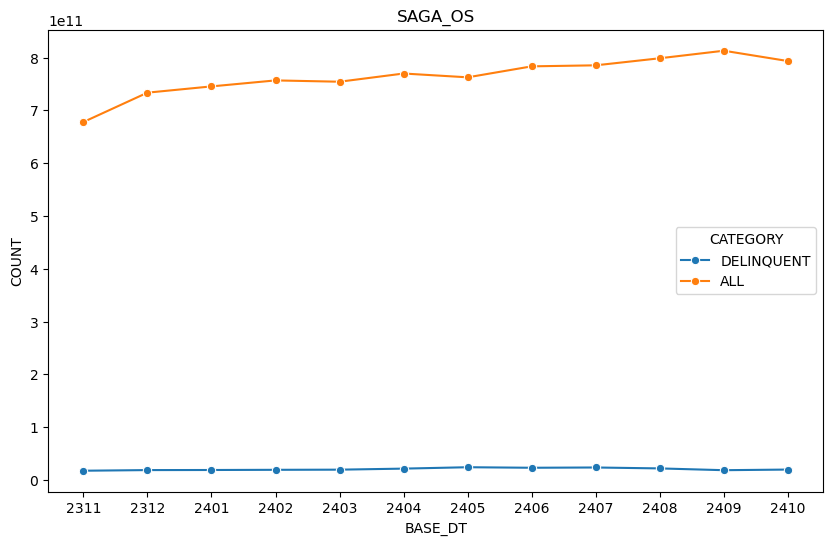

In [205]:
# Plot SAGA count per month
plt.figure(figsize=(10,6))
plt.title("SAGA_OS")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllSAGACount, x="BASE_DT", y='OS', hue='CATEGORY', marker="o")

In [206]:
# create wide df to calaculate percentage
AllSagaCountWide = AllSAGACount[AllSAGACount['CATEGORY']=='DELINQUENT'].merge(
    AllSAGACount[AllSAGACount['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [207]:
# fix field names and shi
AllSagaCountWide.columns = ['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT','MICRO_SEGMENT_x', 'CATEGORY_x',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT', 'CATEGORY_y']
AllSagaCountWide = AllSagaCountWide[['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT']]

In [208]:
AllSagaCountWide

,BASE_DT,ACCT_COUNT_DELINQUENT,OS_DELINQUENT,ACCT_COUNT_ALL,OS_ALL,MICRO_SEGMENT
0,2311,615,1.733557e+10,78358,6.778613e+11,SAGA
1,2312,607,1.853377e+10,83071,7.335104e+11,SAGA
2,2401,580,1.870545e+10,81163,7.453515e+11,SAGA
3,2402,575,1.905721e+10,80489,7.567105e+11,SAGA
4,2403,588,1.933312e+10,79843,7.542105e+11,SAGA
5,2404,620,2.132075e+10,78715,7.697663e+11,SAGA
6,2405,613,2.395302e+10,78079,7.625431e+11,SAGA
7,2406,606,2.294629e+10,77752,7.833538e+11,SAGA
8,2407,618,2.346099e+10,76418,7.852823e+11,SAGA
9,2408,559,2.170487e+10,76462,7.986619e+11,SAGA


In [209]:
# calculate count share
AllSagaCountWide['ACCT_COUNT_SHARE'] = AllSagaCountWide['ACCT_COUNT_DELINQUENT']/AllSagaCountWide['ACCT_COUNT_ALL']

# calculate os share
AllSagaCountWide['OS_SHARE'] = AllSagaCountWide['OS_DELINQUENT']/AllSagaCountWide['OS_ALL']

In [210]:
# longify for visualization
CountShare = AllSagaCountWide[['BASE_DT','ACCT_COUNT_SHARE']]
CountShare.columns = ['BASE_DT','SHARE']
CountShare['VAR'] = 'COUNT'

OSShare = AllSagaCountWide[['BASE_DT','OS_SHARE']]
OSShare.columns = ['BASE_DT','SHARE']
OSShare['VAR'] = 'OS'

# concat the 2 tables
AllShare = pd.concat([CountShare,OSShare], ignore_index=True)
AllShare['BASE_DT'] = AllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_764\2811820419.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CountShare['VAR'] = 'COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_764\2811820419.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OSShare['VAR'] = 'OS'


<Axes: title={'center': 'SAGA_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

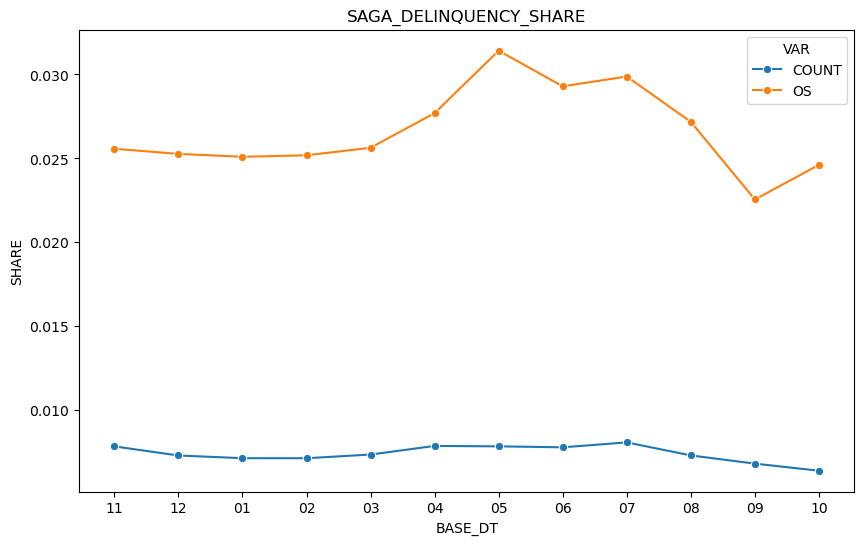

In [211]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("SAGA_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=AllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

### c. All Total vs Bad

In [183]:
# total deli count (review)
TotalDeliCount

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,20231130,1549,3.516816e+10,ALL,DELINQUENT
1,20231229,1468,3.552449e+10,ALL,DELINQUENT
2,20240131,1408,3.592046e+10,ALL,DELINQUENT
3,20240229,1385,3.714974e+10,ALL,DELINQUENT
4,20240328,1432,3.863219e+10,ALL,DELINQUENT
5,20240430,1478,4.255456e+10,ALL,DELINQUENT
6,20240531,1418,4.550060e+10,ALL,DELINQUENT
7,20240628,1407,4.522179e+10,ALL,DELINQUENT
8,20240731,1450,4.527750e+10,ALL,DELINQUENT
9,20240829,1351,4.300646e+10,ALL,DELINQUENT


In [194]:
# Total aggregate
TotalCount = MLs[[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
TotalCount['MICRO_SEGMENT'] = 'ALL'
TotalCount['CATEGORY'] = 'ALL'

In [198]:
# concat tables
AllAll = pd.concat([TotalDeliCount,TotalCount], ignore_index=True)

# format base_dt
AllAll['BASE_DT'] = AllAll['BASE_DT'].str[2:6]

In [199]:
AllAll

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,2311,1549,3.516816e+10,ALL,DELINQUENT
1,2312,1468,3.552449e+10,ALL,DELINQUENT
2,2401,1408,3.592046e+10,ALL,DELINQUENT
3,2402,1385,3.714974e+10,ALL,DELINQUENT
4,2403,1432,3.863219e+10,ALL,DELINQUENT
5,2404,1478,4.255456e+10,ALL,DELINQUENT
6,2405,1418,4.550060e+10,ALL,DELINQUENT
7,2406,1407,4.522179e+10,ALL,DELINQUENT
8,2407,1450,4.527750e+10,ALL,DELINQUENT
9,2408,1351,4.300646e+10,ALL,DELINQUENT


<Axes: title={'center': 'ALL_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

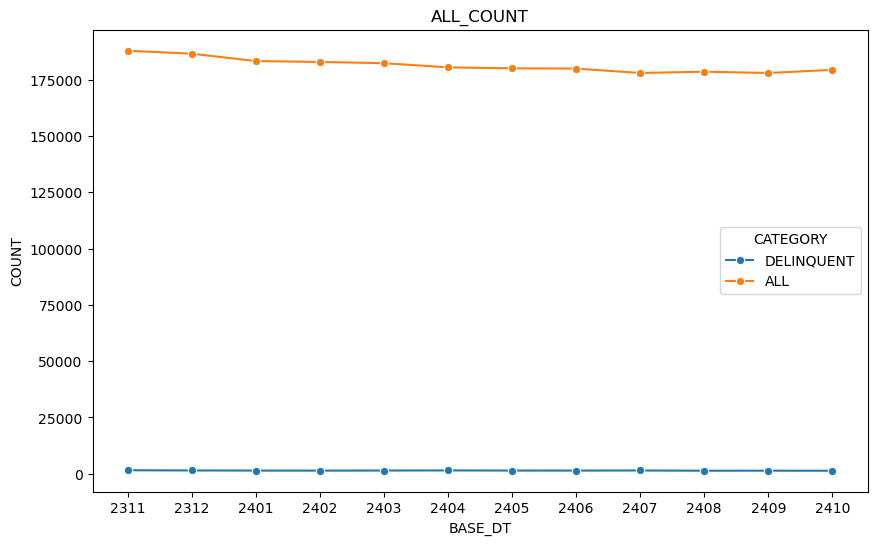

In [200]:
# Plot All count per month
plt.figure(figsize=(10,6))
plt.title("ALL_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllAll, x="BASE_DT", y='ACCT_COUNT', hue='CATEGORY', marker="o")

<Axes: title={'center': 'ALL_OS'}, xlabel='BASE_DT', ylabel='OS'>

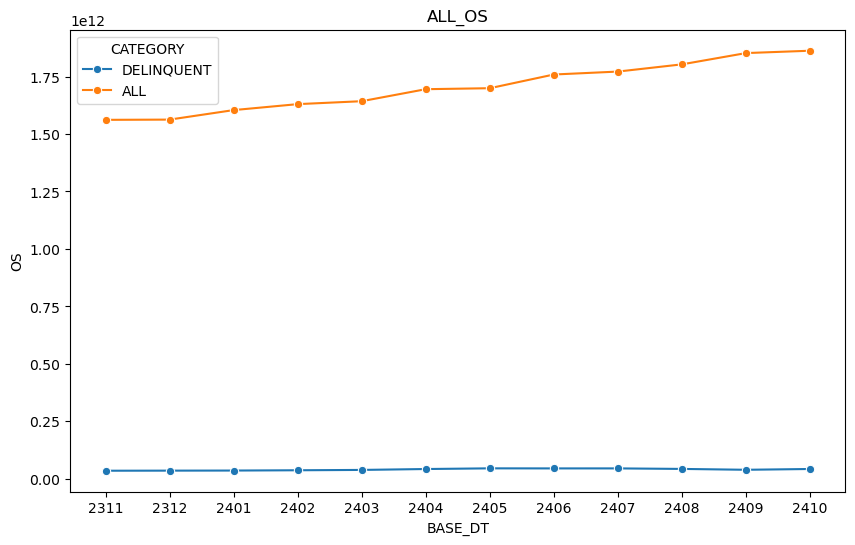

In [214]:
# Plot All count per month
plt.figure(figsize=(10,6))
plt.title("ALL_OS")
plt.xlabel("BASE_DT")
plt.ylabel("OS")
# plt.ylim((0,2000))
sns.lineplot(data=AllAll, x="BASE_DT", y='OS', hue='CATEGORY', marker="o")

In [215]:
# create wide df to calaculate percentage
AllCountWide = AllAll[AllAll['CATEGORY']=='DELINQUENT'].merge(
    AllAll[AllAll['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [217]:
# fix field names and shi
AllCountWide.columns = ['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT','MICRO_SEGMENT_x', 'CATEGORY_x',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT', 'CATEGORY_y']
AllCountWide = AllCountWide[['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT']]

In [218]:
# calculate count share
AllCountWide['ACCT_COUNT_SHARE'] = AllCountWide['ACCT_COUNT_DELINQUENT']/AllCountWide['ACCT_COUNT_ALL']

# calculate os share
AllCountWide['OS_SHARE'] = AllCountWide['OS_DELINQUENT']/AllCountWide['OS_ALL']

In [219]:
# longify for visualization
AllCountShare = AllCountWide[['BASE_DT','ACCT_COUNT_SHARE']]
AllCountShare.columns = ['BASE_DT','SHARE']
AllCountShare['VAR'] = 'COUNT'

AllOSShare = AllCountWide[['BASE_DT','OS_SHARE']]
AllOSShare.columns = ['BASE_DT','SHARE']
AllOSShare['VAR'] = 'OS'

# concat the 2 tables
AllAllShare = pd.concat([AllCountShare,AllOSShare], ignore_index=True)
AllAllShare['BASE_DT'] = AllAllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_764\808844126.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllCountShare['VAR'] = 'COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_764\808844126.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllOSShare['VAR'] = 'OS'


<Axes: title={'center': 'TOTAL_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

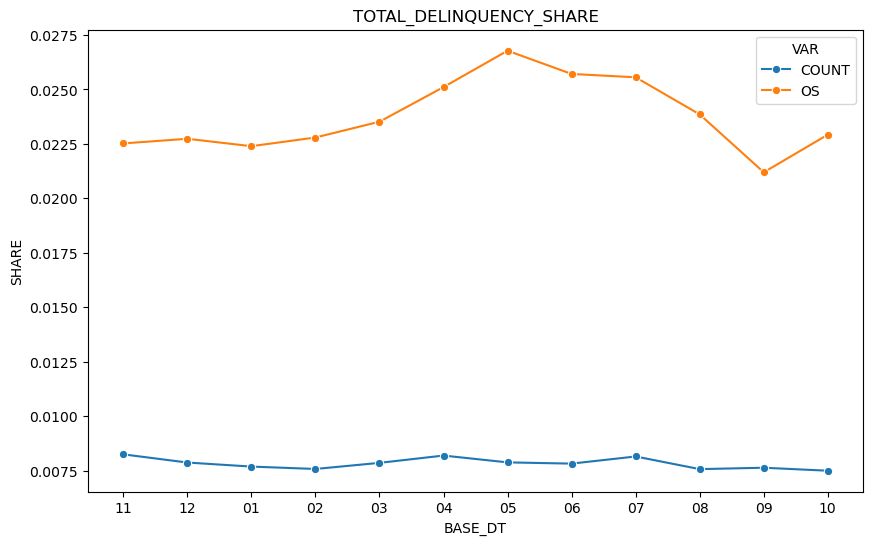

In [224]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("TOTAL_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=AllAllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

### d. SAGA Monthly New Bad Debt

In [158]:
# set dataframe for dpd change calculation
DPDMonthly = MLs[['BASE_DT', 'AGREE_ID', 'PASTDUE_DAYS']].reset_index()

In [159]:
# checking pastdue values
DPDMonthly['PASTDUE_DAYS'].value_counts()

PASTDUE_DAYS
0      2108866
1        40809
30       10727
60        6189
90        4365
120       3585
150       2842
210         62
180          5
Name: count, dtype: int64

In [160]:
# create pivot table
DPDMonthlyPivot = DPDMonthly.pivot(index='AGREE_ID',
                                   columns='BASE_DT',
                                   values='PASTDUE_DAYS')

In [161]:
# flaten columns
DPDMonthlyPivot = DPDMonthlyPivot.rename_axis(index=None, columns=None).reset_index()

In [162]:
DPDMonthlyPivot.columns

Index(['index', '20231130', '20231229', '20240131', '20240229', '20240328',
       '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
       '20241031'],
      dtype='object')

In [163]:
# rename columns
DPDMonthlyPivot.columns = [
    'AGREE_ID', '20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

In [164]:
# fillna with 0
DPDMonthlyPivot.fillna(0, inplace=True)

# date for loop
dateCol = ['20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

# calculate dpd change for all dates
for i in range(1,len(dateCol)):
    prevDate = dateCol[i-1]
    date = dateCol[i]
    DPDMonthlyPivot[f'DELINQUENT_{date}'] = DPDMonthlyPivot.apply(
        lambda x: 1 if x[prevDate]<30 and x[date]>=30 else 0,
        axis=1)

In [165]:
# check value
DPDMonthlyPivot[['DELINQUENT_20240430']].value_counts()

DELINQUENT_20240430
0                      255118
1                         579
Name: count, dtype: int64

In [166]:
# take only used cols
usedCols = [list(DPDMonthlyPivot.columns)[0]]+list(DPDMonthlyPivot.columns)[13:]
DPDMonthlyPivot = DPDMonthlyPivot[usedCols]

In [167]:
# longify
DPDMonthlyLong = pd.wide_to_long(DPDMonthlyPivot,
                                 stubnames='DELINQUENT',
                                 i = 'AGREE_ID',
                                 j = 'BASE_DT',
                                 sep = '_')

In [168]:
# reset index and change base_dt type to string
DPDMonthlyLong = DPDMonthlyLong.reset_index()
DPDMonthlyLong['BASE_DT'] = DPDMonthlyLong['BASE_DT'].astype(str)

In [169]:
DPDMonthlyLong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2812667 entries, 0 to 2812666
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   AGREE_ID    object
 1   BASE_DT     object
 2   DELINQUENT  int64 
dtypes: int64(1), object(2)
memory usage: 64.4+ MB


In [170]:
MLs['DELINQUENT'].value_counts()

DELINQUENT
0.0    1982292
1.0       7273
Name: count, dtype: int64

In [ ]:
# merge delinquency flag to original data
MLs = MLs.merge(DPDMonthlyLong[['AGREE_ID', 'BASE_DT', 'DELINQUENT']], on=['AGREE_ID', 'BASE_DT'], how='left')

In [172]:
# group data for visualization
monthlyDeli = MLs[(MLs['SAGA_FLAG']=='SAGA') & (MLs['DELINQUENT']==1)][['BASE_DT', 'DELINQUENT', 'BAL']].groupby('BASE_DT').agg(ACCT_COUNT=('DELINQUENT','sum'), OS=('BAL','sum')).reset_index()
monthlyDeliAll = MLs[MLs['DELINQUENT']==1][['BASE_DT', 'DELINQUENT','BAL']].groupby('BASE_DT').agg(ACCT_COUNT=('DELINQUENT','sum'), OS=('BAL','sum')).reset_index()

In [173]:
# flag data
monthlyDeli['MICRO_SEGMENT'] = 'SAGA'
monthlyDeliAll['MICRO_SEGMENT'] = 'ALL'

In [ ]:
# combine the data
MonthlyDeliComb = pd.concat([monthlyDeli,monthlyDeliAll], ignore_index=True)

# format data
MonthlyDeliComb['BASE_DT'] = MonthlyDeliComb['BASE_DT'].str[2:6]

# exclude first month because no data of new delinquency
MonthlyDeliComb = MonthlyDeliComb[MonthlyDeliComb['BASE_DT']!='2311']

<Axes: title={'center': 'DELINQUENCY_GROWTH'}, xlabel='BASE_DT', ylabel='COUNT'>

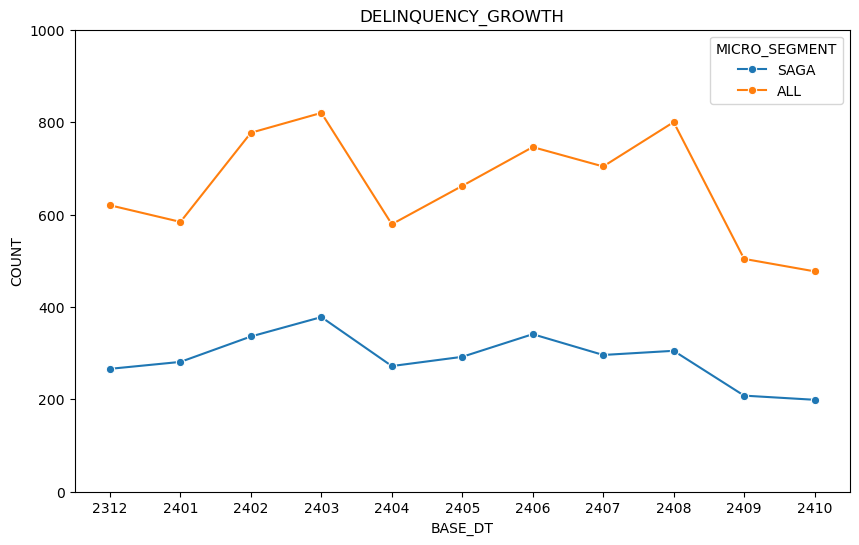

In [175]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("MONTHLY_DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylim((0,1000))
plt.ylabel("COUNT")
sns.lineplot(data=MonthlyDeliComb, x="BASE_DT", y='ACCT_COUNT', hue='MICRO_SEGMENT', marker="o")

<Axes: title={'center': 'MONTHLY_DELINQUENCY_os'}, xlabel='BASE_DT', ylabel='os'>

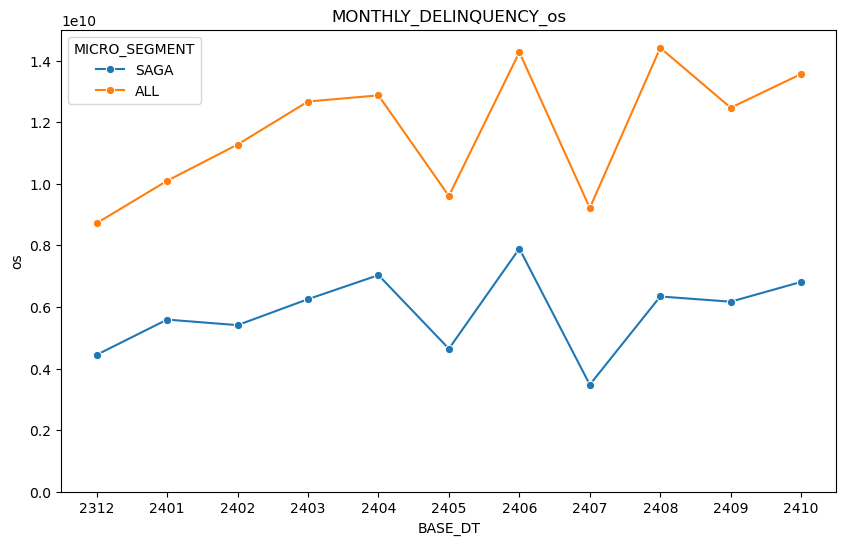

In [179]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("MONTHLY_DELINQUENCY_os")
plt.xlabel("BASE_DT")
plt.ylim((0,15000000000))
plt.ylabel("os")
sns.lineplot(data=MonthlyDeliComb, x="BASE_DT", y='OS', hue='MICRO_SEGMENT', marker="o")

## 2. By GCIF

In [ ]:
MLs.duplicated().sum()

In [245]:
# create GCIF grouped data
MLsGCIFGPD = MLs[['BASE_DT','GCIF_NO','CURR_LMT_AMT','BAL']].groupby(
    ['BASE_DT','GCIF_NO']).agg(
        SUM_LMT=('CURR_LMT_AMT','sum'),
        SUM_BAL=('BAL','sum'),
        NOA=('BASE_DT','count')
    ).reset_index()

In [240]:
# create GCIF distinct data
MLsGCIFProc = MLs[['BASE_DT','GCIF_NO','SAGA_FLAG','PASTDUE_DAYS']]

In [241]:
# map to integer SAGA flag
SAGAMap = {'SAGA':1,'NON-SAGA':0}
MLsGCIFProc['SAGA_FLAG'] = MLsGCIFProc['SAGA_FLAG'].map(SAGAMap)

C:\Users\MR38804\AppData\Local\Temp\ipykernel_764\49022384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MLsGCIFProc['SAGA_FLAG'] = MLsGCIFProc['SAGA_FLAG'].map(SAGAMap)


In [246]:
# create categorical GCIF grouped data
MLsGCIFGPD2 = MLsGCIFProc.groupby(
    ['BASE_DT','GCIF_NO']).agg(
        SAGA_FLAG=('SAGA_FLAG','max'),
        PASTDUE_DAYS_MAX=('PASTDUE_DAYS','max'),
).reset_index()

In [247]:
# merge the numeric and categorical data
MLsGCIF = MLsGCIFGPD.merge(MLsGCIFGPD2, on=['BASE_DT','GCIF_NO'], how='left')

In [248]:
MLsGCIF

,BASE_DT,GCIF_NO,SUM_LMT,SUM_BAL,NOA,SAGA_FLAG,PASTDUE_DAYS_MAX
0,20231130,EX0000000009531013,39812500.00,0.0,7,NaN,0
1,20231130,EX0000000009531021,12000000.00,0.0,2,NaN,0
2,20231130,EX0000000009531039,2250000.00,0.0,2,NaN,0
3,20231130,EX0000000009531047,44052764.61,480990.0,11,NaN,0
4,20231130,EX0000000009531054,11598367.00,196734.0,6,NaN,0
...,...,...,...,...,...,...,...
1469019,20241031,G910398577,8000000.00,7610999.0,1,0.0,0
1469020,20241031,G910398734,35000000.00,1497748.0,1,0.0,0
1469021,20241031,G910399518,70000000.00,9286706.0,1,0.0,0
1469022,20241031,G910402478,12000000.00,1287038.0,1,0.0,0


In [249]:
# map data
MLsGCIF['SAGA_FLAG'] = MLsGCIF['SAGA_FLAG'].map({1:'SAGA',0:'NON-SAGA'})
MLsGCIF['CC_STATUS'] = MLsGCIF.apply(
    lambda x: 'DELINQUENT' if x['PASTDUE_DAYS_MAX']>=30 else 'PERFORMING' if x['PASTDUE_DAYS_MAX']==0 else 'GRACE_PERIOD',
    axis=1)

In [251]:
MLsGCIF

,BASE_DT,GCIF_NO,SUM_LMT,SUM_BAL,NOA,SAGA_FLAG,PASTDUE_DAYS_MAX,CC_STATUS
0,20231130,EX0000000009531013,39812500.00,0.0,7,NaN,0,PERFORMING
1,20231130,EX0000000009531021,12000000.00,0.0,2,NaN,0,PERFORMING
2,20231130,EX0000000009531039,2250000.00,0.0,2,NaN,0,PERFORMING
3,20231130,EX0000000009531047,44052764.61,480990.0,11,NaN,0,PERFORMING
4,20231130,EX0000000009531054,11598367.00,196734.0,6,NaN,0,PERFORMING
...,...,...,...,...,...,...,...,...
1469019,20241031,G910398577,8000000.00,7610999.0,1,NON-SAGA,0,PERFORMING
1469020,20241031,G910398734,35000000.00,1497748.0,1,NON-SAGA,0,PERFORMING
1469021,20241031,G910399518,70000000.00,9286706.0,1,NON-SAGA,0,PERFORMING
1469022,20241031,G910402478,12000000.00,1287038.0,1,NON-SAGA,0,PERFORMING


In [261]:
# Total all GCIF aggregate
TotalGCIFCount = MLsGCIF.groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
TotalGCIFCount['MICRO_SEGMENT'] = 'ALL'
TotalGCIFCount['CATEGORY'] = 'ALL'

In [262]:
# Total delinquent GCIF aggregate
TotalDeliGCIFCount = MLsGCIF[MLsGCIF['CC_STATUS']=='DELINQUENT'].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
TotalDeliGCIFCount['MICRO_SEGMENT'] = 'ALL'
TotalDeliGCIFCount['CATEGORY'] = 'DELINQUENT'

In [263]:
# Total SAGA GCIF aggregate
SAGAGCIFCount = MLsGCIF[MLsGCIF['SAGA_FLAG']=='SAGA'].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
SAGAGCIFCount['MICRO_SEGMENT'] = 'SAGA'
SAGAGCIFCount['CATEGORY'] = 'ALL'

In [264]:
# Total SAGA delinquent GCIF aggregate
SAGADeliGCIFCount = MLsGCIF[(MLsGCIF['SAGA_FLAG']=='SAGA')&(MLsGCIF['CC_STATUS']=='DELINQUENT')].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
SAGADeliGCIFCount['MICRO_SEGMENT'] = 'SAGA'
SAGADeliGCIFCount['CATEGORY'] = 'DELINQUENT'

In [265]:
TotalGCIFCount

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,20231130,123670,3.749174e+12,1.561560e+12,187885,ALL,ALL
1,20231229,123424,3.775570e+12,1.562580e+12,186569,ALL,ALL
2,20240131,122366,3.848475e+12,1.603963e+12,183281,ALL,ALL
3,20240229,122966,3.925737e+12,1.629879e+12,182894,ALL,ALL
4,20240328,123125,3.935050e+12,1.642677e+12,182350,ALL,ALL
5,20240430,122583,3.977078e+12,1.694901e+12,180496,ALL,ALL
6,20240531,122389,4.037320e+12,1.699164e+12,180056,ALL,ALL
7,20240628,122319,4.130127e+12,1.758796e+12,179964,ALL,ALL
8,20240731,121272,4.370452e+12,1.771556e+12,177991,ALL,ALL
9,20240829,121461,4.406276e+12,1.802961e+12,178580,ALL,ALL


### a. SAGA vs ALL Bad Debt

<Axes: title={'center': 'DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

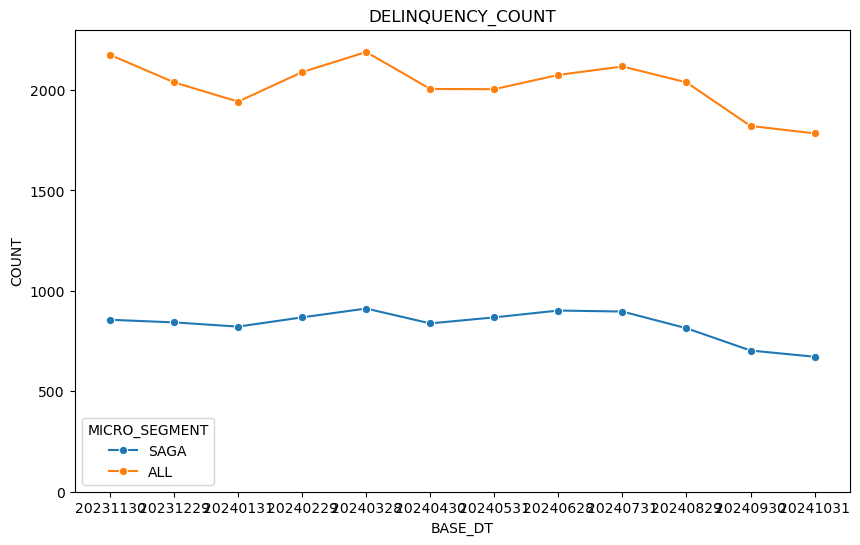

In [ ]:
# concat data
GCIFPlot1 = pd.concat([SAGADeliGCIFCount,TotalDeliGCIFCount])
GCIFPlot1['BASE_DT'] = GCIFPlot1['BASE_DT'].str[2:6]

# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
plt.ylim((0,2300))
sns.lineplot(data=), x="BASE_DT", y='CUST_NUM', hue='MICRO_SEGMENT', marker="o")

In [ ]:
# TotalDeliGCIFCount
# SAGADeliGCIFCount

1. Hitung total bad debt SAGA all month
2. Bandingkan bad debt SAGA vs all other CC
2. Bandingkan 